==============================================================================================
## Practicum 4: Descriptors extraction for object detection, based on template matching, ORB, and HOG
==============================================================================================

In this laboratory we will treat the following main topics:

1) Template matching
    - Normalized Cross-correlation
    - Application to object (eye) detection 

2) Image Descriptors: "Sliding window" and HOG image descriptor
   - Application to object (car) detection

3) Image matching (recognition by correspondance) based on feature extraction (ORB)
    - Application to object (logo) detection
    
In order to complete this practicum, the following concepts need to be understood: template matching, feature localization (Harris, Censure), feature descriptor (HOG,ORB, Sift) methods.

All code should be commented in English. Answers of the questions and comments on the exercises should be given in English too.

It is highly recommendable to structure the code in functions in order to reuse code for different tests and images and make it shorter and more readable. Specially the visualization commands should be encapsulated in separate functions.

## 4.1 Template matching

4.1.1 Given the image 'einstein.png' and the template 'eye.png', detect the location of the template in the image comparing the use of:
- euclidean distance (hint: norm() in numpy.linalg).
- normalized cross-correlation (hint: match_template() of skimage.feature).

Hint: you can take as an example, the template matching on the [coin exercise](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py) in skimage.
Don't forget to normalize the images (having pixel values between [0,1]) before comparing them.

In [1]:
from skimage import io, data, exposure
from skimage.feature import match_template, hog
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import rotate
import numpy as np

%matplotlib inline

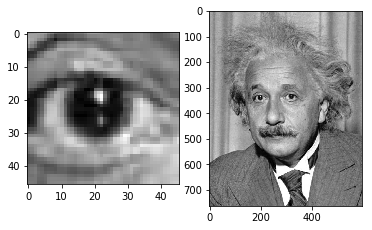

In [2]:
plt.subplot(1,2,1)
eye = rgb2gray(io.imread('./images/eye.png'))
plt.imshow(eye, cmap='gray')

plt.subplot(1,2,2)
einstein = rgb2gray(io.imread('./images/einstein.png'))
plt.imshow(einstein, cmap='gray')

plt.show()

In [74]:
''' Visualization and template matching functions definition '''

def euclidean_match(image, template):
    
    ix, iy = image.shape
    tx, ty = template.shape
    
    # Resulting image will have different dimension to the original one. It will be reduced by the size
    # of the template.
    result = np.zeros((ix - tx, iy - ty))
    # Computes Euclidean distance.
    euclidean = lambda a, b: np.linalg.norm(a - b)
    
    for r in range(ix - tx):
        # Distance between each cell (size of template) and the template.
        result[r] = [euclidean(image[r:r + tx, c:c + ty], template) for c in range(iy - ty)]
    
    # Returned image is normalized as required in the exercise.
    return result/np.max(result)
    
def cross_correlation_match(image, template):
    
    result = match_template(image, template)
    # Returned image is normalized as required in the exercise.
    return result/np.max(result)
    
def plot_n_images(n, images, titles, fig_title=None, cmap=None):
    
    fig, axs = plt.subplots(1, n)
    fig.set_size_inches(10, 10)
    if fig_title: print(fig_title)
    #fig.suptitle(fig_title)
    # Plots images with title and no axis.
    for i in range(n):
        axs[i].axis('off')
        axs[i].imshow(images[i], cmap)
        axs[i].set_title(titles[i])

    plt.show()

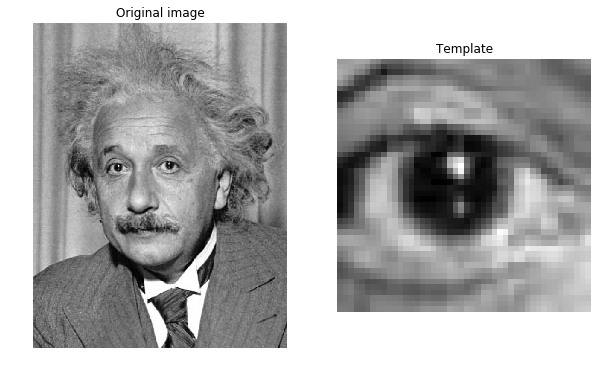

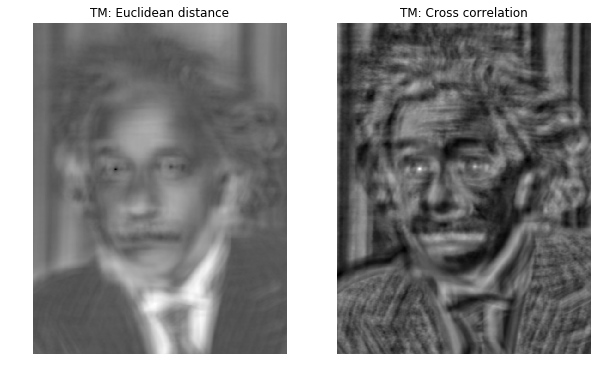

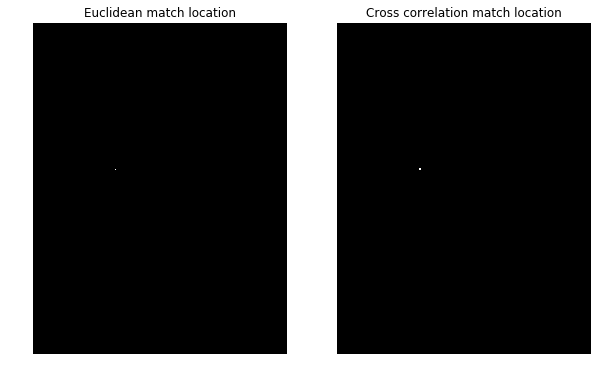

In [5]:
eu = euclidean_match(einstein, eye) 
cr = cross_correlation_match(einstein, eye)

eu_marked = np.copy(eu)
cr_marked = np.copy(eu)

plot_n_images(2, [einstein, eye], ["Original image", "Template"], "", 'gray')
plot_n_images(2, [eu, cr], ["TM: Euclidean distance", "TM: Cross correlation"], "", 'gray')
# Using a mask, the template match location can be extracted for later comparison.
plot_n_images(2, [eu < 0.1, cr > 0.8], ["Euclidean match location", "Cross correlation match location"], "", 'gray')

4.1.2 How does the result of the template matching change if the image changes its contrast (for example if you make it clearer or darker)? To this purpose, read the images "einstein_br.png" and "einstein_mask.png".

Visualize the normalized cross-correlation image between the template and the image as well as this very same image in a binarized form in order to show where is the minimal distance between the template and the image. 
* How does the minimum distance between the template and the image change? 
* What are the minimal distance pixels in the correlation images? 
* What are the distances between the template and the image around the eyes of the image? 

Use titles of the figures to explain what is displayed.


Using 'einstein_br.png' image


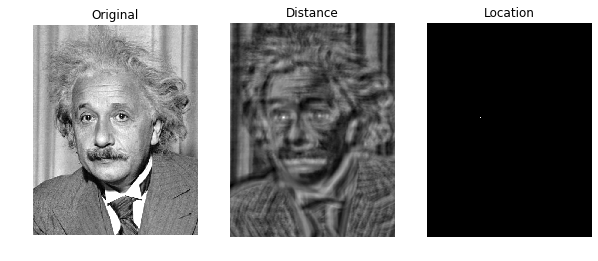

Results with the original image binarized:


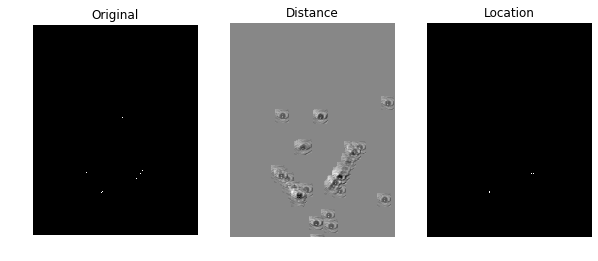

Using 'einstein_mask.png' image


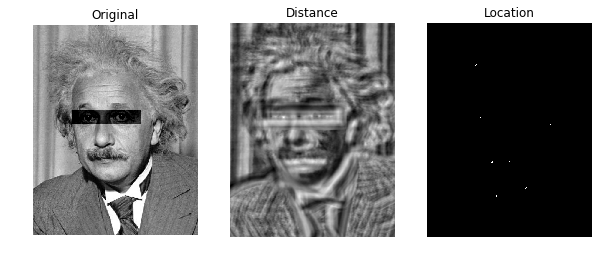

Results with the original image binarized:


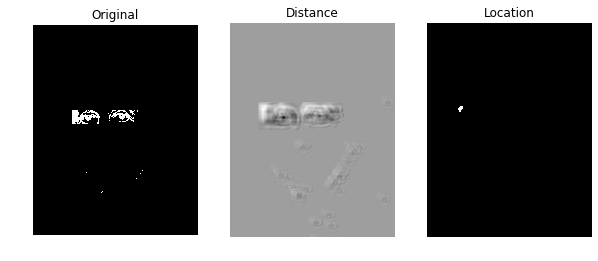

In [58]:
ebr = rgb2gray(io.imread('./images/einstein_br.png'))
ebr_bin = np.where(ebr <= 0.1, 1, 0)
emsk = rgb2gray(io.imread('./images/einstein_mask.png'))
emsk_bin = np.where(emsk <= 0.3, 1, 0)

cr_ebr, cr_emsk = cross_correlation_match(ebr, eye), cross_correlation_match(emsk, eye)
cr_ebr_bin, cr_emsk_bin = cross_correlation_match(ebr_bin, eye), cross_correlation_match(emsk_bin, eye)
titles = ["Original", "Distance", "Location"]

plot_n_images(3, [ebr, cr_ebr, cr_ebr > 0.8], titles, "Using 'einstein_br.png' image", 'gray')
print("Results with the original image binarized:")
plot_n_images(3, [ebr_bin, cr_ebr_bin, cr_ebr_bin > 0.8], titles, "", 'gray')
plot_n_images(3, [emsk, cr_emsk, cr_emsk > 0.8], titles, "Using 'einstein_mask.png' image", 'gray')
print("Results with the original image binarized:")
plot_n_images(3, [emsk_bin, cr_emsk_bin, cr_emsk_bin > 0.8], titles, "", 'gray')

**Answers:**

**1.** The distance between both template and images changes so that 1 represents a match and 0 doesn't.

**2.** The minimal distance pixels in the correlation images are pixels which are quite similar in the image as well as the template.

**3.** The distances are nearly 0 as the template finds a good match.

4.1.3 How does the result of the template matching changes if instead the template is the one that changes its contrast (for example if you make it clearer or darker)? To this purpose, use the 'eye_br.png' template.

Using brightened template


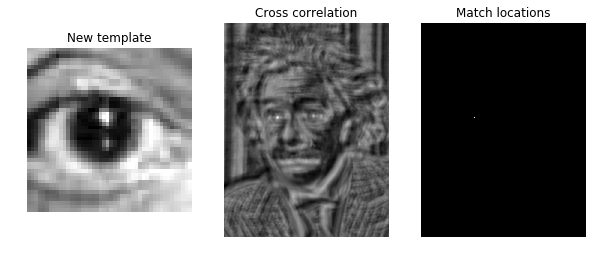

Using normal template


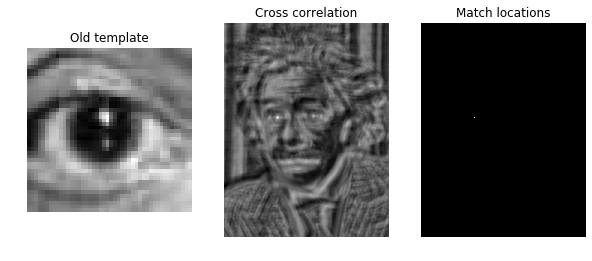

In [8]:
eye_br = rgb2gray(io.imread('./images/eye_br.png'))
cr = cross_correlation_match(einstein, eye_br)
cr2 = cross_correlation_match(einstein, eye)

plot_n_images(3, [eye_br, cr, cr > 0.8], ["New template", "Cross correlation", "Match locations"], "Using brightened template", 'gray')
plot_n_images(3, [eye, cr2, cr2 > 0.8], ["Old template", "Cross correlation", "Match locations"], "Using normal template", 'gray')

**Comment:** No major changes are seen. As explained in class, normalized cross is invariant to local average intensity and contrast. 

4.1.4 Check how the result changes if the template is rotated. Visualize the template and its rotation by 10º, 15º and 20º. Obtain again the template matching using the Euclidean distance and normalized cross-correlation.
Help: use the function rotate() in skimage.transform

Template rotated 10º


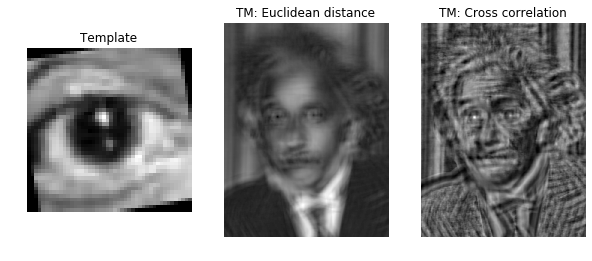

Template rotated 15º


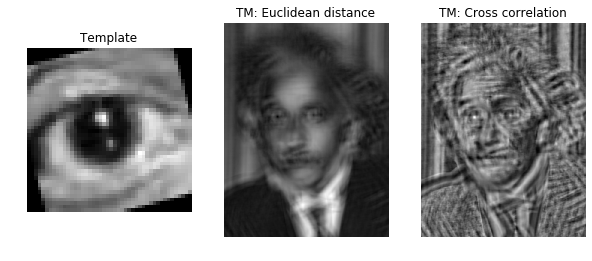

Template rotated 20º


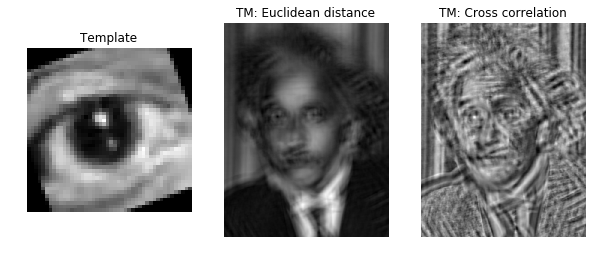

In [9]:
eye10, eye15, eye20 = rotate(eye, 10), rotate(eye, 15), rotate(eye, 20)
eu10, eu15, eu20 = euclidean_match(einstein, eye10), euclidean_match(einstein, eye15), euclidean_match(einstein, eye20)
cr10, cr15, cr20 = cross_correlation_match(einstein, eye10), cross_correlation_match(einstein, eye15), cross_correlation_match(einstein, eye20)

titles = ["Template", "TM: Euclidean distance", "TM: Cross correlation"]

plot_n_images(3, [eye10, eu10, cr10], titles, "Template rotated 10º", 'gray')
plot_n_images(3, [eye15, eu15, cr15], titles, "Template rotated 15º", 'gray')
plot_n_images(3, [eye20, eu20, cr20], titles, "Template rotated 20º", 'gray')

Comment what is the template matching process, what advantages and disadvantages it has, how sensible is to image deformation in photometric and spatial dimensions, what parameters it has and which measure for image comparisons works better.

**Comment:** The template matching process is a technique that allows a feature, texture or another picture to be found or identified in an image. It allows us to find different elements in an image. However it needs a good, robust and invariant similarity measure to operate perfectly. It's quite sensible to photometric deformations. Comparison: *Euclidean distance* is fast but very sensitive, *Correlation* is less sensitive to illumination changes and *Normalized Cross Correlation* is less sensitive to variance in the mask.

# 4.2 Histogram of Oriented Gradients


The Histogram of Oriented Gradients (HOG) feature descriptor is classical image descriptor for object detection.

Given the image 'car_template.png' and the folder 'cars', apply the HOG descriptor in order to detect where there is a car in the images in the folder 'car'. To this purpose, apply the "sliding window" technique. The algorithm can be:

a) Read the car template ('car_template.png') and obtain its HOG descriptor. Visualize it. [Help](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py) 

b) Read images from the folder "car", slide a window on each image, obtain the HOG descriptor and compare to the HOG descriptor of the car template. 

c) Visualize the location in the image that is the most similar to the car template. What distance will you use to compare both HOG descriptors of the car template and the image region? Compare if there is any difference in their results. 

d) Compute in how many images the cars were detected correctly and discuss the algorithm failures. What do you think can be the reasons for the failure?

Hint: the HOG detector function is in the skimage.feature library. 

If you want to accelerate algorithm execution, you can apply the sliding window with a step of X pixels (e.g. X=5).

Discuss what is the HOG descriptor, what are the parameters of the algorithm, which are the optimal values for the car detection testing several values of the parameters up to your criterion. Do you see any advantages of the HOG-based object detector compared to the template-based object detection? (The answer should be up to 10-15 lines).

In [132]:
''' Visualization and HOG functions definition '''

def compute_hog(image, ori=8, ppc=(16, 16), cpm=(1, 1)):
    
    # Returns HOG descriptor as well as a HOG image.
    fd, hog_image = hog(image, orientations=ori, pixels_per_cell=ppc, cells_per_block=cpm, visualize=True)
    # Obtained image is rescaled to achieve better display.
    hir = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    return hir

def hog_collection(col, template, step=1, skip_frames=False):
    
    
    tx, ty = template.shape
    # For saving match location and distance.
    pcomp, px, py = float('inf'), float('inf'), float('inf')
    # Template's hog only needs to be obtained once.
    ht = compute_hog(template)
    
    # Euclidean distance for comparing HOGs.
    compare = lambda a, b: np.linalg.norm(b - a)
    improvement = lambda x: True if x < pcomp else False
    frame_step, locations = 1, []
    
    # When True, the step for the images in the collection is increased. This reduces the amount of 
    # images that are checked and accelerates execution. The step on the window loops can also be
    # changed to reduce execution time.
    if skip_frames: frame_step = int(0.45*len(col))
    
    for i in range(0, len(col), frame_step):
        image = col[i]
        # Dimensions for image need to be updated for every frame. This is because not all the images
        # in the collection (ic) have the same shape.
        ix, iy = col[i].shape
        for r in range(0, ix - tx, step):
            for c in range(0, iy - ty, step):
                # Comparing HOGs.
                comp = compare(compute_hog(image[r:r + tx, c:c + ty]), ht)

                if improvement(comp):
                    # Saving coordinates if better match.
                    pcomp, px, py = comp, r, c
                    locations.append((px, py, i))
    
    return pcomp, px, py, locations

def show_all_matches(images, template, loc, fig_title=None, cmap=None):
    
    # Same as plot_n_images but for collections of images. It adapts to the input quantity.
    tx, ty = template.shape
    xs, ys, frme_nmbr = [x for x, _, _ in loc], [y for _, y, _ in loc], [fn for _, _, fn in loc]
    nmbr, cols = len(loc), 3
    rows, sel = nmbr/cols, 0
    rows = int(rows) if rows == int(rows) else int(rows) + 1
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols)
    fig.set_size_inches(20, 20)
    
    if fig_title: print(fig_title)
        
    for i in range(rows):
        for j in range(cols):
            
            frame, y, x = frme_nmbr[sel], ys[sel], xs[sel]

            axs[i, j].axis('off')
            axs[i, j].imshow(images[frame], cmap)
            axs[i, j].set_title("Frame #{}".format(frame))
            # For some weird reason, Rectangle function from matplotlib takes height and width parameters
            # in an untraditional order. First height and then width. The same happens with the corners 
            # coordinates.
            rect = plt.Rectangle((y, x), ty, tx, edgecolor='b', facecolor='none', lw=1.2)
            axs[i, j].add_patch(rect)
            sel -= -1
            
            if sel == len(loc): return

    plt.show()    

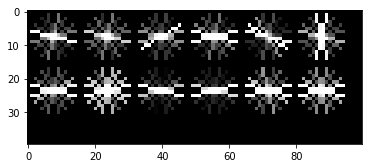

In [62]:
car = io.imread("./images/car_template.png") 
plt.imshow(compute_hog(car), cmap='gray')

In [63]:
ic = io.ImageCollection('images/TestImages/*.pgm')
comp, bx, by, loc = hog_collection(ic, car, step=5)

Template matches:


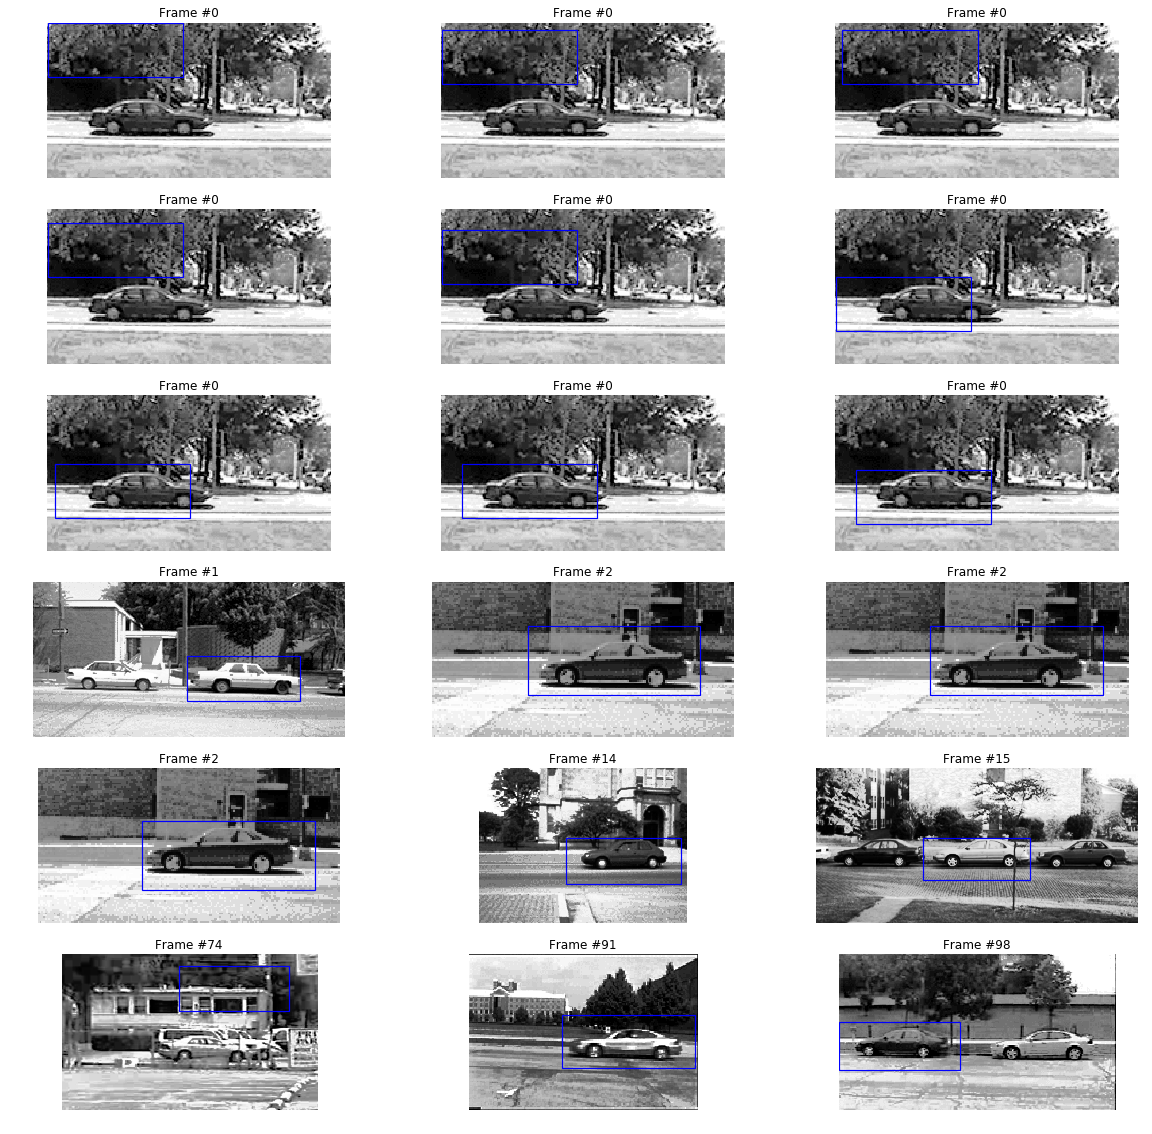

In [134]:
show_all_matches(ic, car, loc, fig_title="Template matches:", cmap='gray')

**Answers:**

**c.** The Euclidean distance has been used to compare HOG descriptors.

**d.** In total the algorithm made 18 detections, 12 of which are accurate and correct. The main reason that makes detections fail is similar lines in both gradients mark the window as a car. Since the car is mostly horitzontal lines, a window with similar horitzontal lines might be marked as a car.

**Algorithm discussion:**

The Histogram of Oriented Gradients is a feature decriptor that counts occurrences of gradient orientation in localized portions of an image. It is commonly used in object detection algorithms.

The 'hog' function from the Skimage library has the following basic parameters:

    · orientations -> number of orientations to keep track on
    · pixels_per_cells -> sets the size of a cell
    · cells_per_block -> sets the number of cells for each block
For the car detection testing, small parameters will do the trick. Since it is relatively big and has mainly straight horitzontals lines, a big number isn't needed and lots of pixels per cell aren't required. For detection of smaller objects, more pixels would do the trick.
In comparison to the template-based object detector, HOG is illumination invariant as well as invariant to small spatial changes which makes it better for object detection.

<s>answer has 10 lines<s>

# 4.3 ORB feature detector and binary descriptor

Let us consider the problem of feature extraction that contains two subproblems: 
- feature location, 
- image feature description.

In theory classes, we saw two feature extraction methods: SIFT and ORB. Let us focus on ORB.

**4.3.1** Check if ORB is  scale and rotation invariant, a property that is very important for real-time applications.

**Hint:** `ORB` is a function within the module `skimage.feature`
                             
**Help**: We suggest to have a look at the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html) how to compute the ORB descriptors and find the descriptors match. You can use the function match_descriptors from `skimage.feature` module in order to compute and show the similar detected descriptors of the given images. 

a) Detect the correspondences between the model image `starbucks.jpg` with the scene image `starbucks6.jpg`. You can adapt the code from the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html) above. Define the algorithm in terms of functions in order to be able to apply it on different images. Comment the code in detail.

Hint: If the function plot_matches() gives you an error you can use the plot_matches_aux() at the end of this file.

In [ ]:
''' Visualization and ORB functions definition '''


b) Repeate the experiment comparing the "starbucks.jpg" image as a model, and showing its matches to all Starbucks images, sorting them based on their similarity to the model. Comment when the algorithm works best. 

c) Repeate the experiment in (b): 
- Changing the orientation of the model image by rotating it and comparing it with its original version. Help: you can use the rotate() function from skimage.transform 
- Change the scale and orientation of the scene image and compare it with the model image.

Help: To do so, you can use the function given below as example:

import transform as tf
rotationdegrees = 180
img_rotated = tf.rotate(image2transform, rotationdegrees)

or

tform = tf.AffineTransform(scale=(1.2, 1.2), translation=(0, -100))
img_transformed = tf.warp(image2transform, tform)

**Optional:** Repeate the experiment with a new group of images. You could use Coca-Cola advertisements or from another famous brand, easily to find on internet.



### Analysis of the applied techniques and results

- What are the advantages of the ORB object detection with respect to the HOG and template object detector?

- What would happen if you analyse an image that does not contain the Starbucks logo? 

- Could you think of ways of defining a quality measure for the correspondance between two images? (no need of implementing it) 

## Delivery

All code sould be commented in English. Answers of the questions should be given in English too.

Compressed file **P4_Student1_Student2.zip** that includes:
- The notebook P1_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
- The images used that are not provided in P1.zip.

**Deadline (Campus Virtual): November 26th, 23:59.** 

In [ ]:
#Appendix: In case the plot_matches() function gives you some problems, you can use the following one:

from skimage.util import img_as_float
import numpy as np

def plot_matches_aux(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1 = img_as_float(image1)
    image2 = img_as_float(image2)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]),
                '-', color=color)